# Overview: 

This notebook is created to do tasks given in this issue: [Visualization for misclassification](https://github.com/mozilla/PRESC/issues/7)

# Task:
- Develop a visualization that helps dig into misclassified datapoints in the test set.



I have used two classifiers to show misclassification. 
- Decision tree: for showing and calculating misclassification in confusion matrix.
- SVM: for showing misclassification at different datapoints in the test set by tuning the value of C - The Penalty Parameter.


In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pandas_profiling

# Import packages to visualize the classifer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, validation_curve

# Import packages to do the classifying
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.utils.multiclass import unique_labels

In [2]:
df = pd.read_csv("../../datasets/defaults.csv")

In [3]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})

In [4]:
target = df['def_pay'].copy()

In [5]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
#X = df[features].copy()
#features.columns
features = df[features].copy()
features.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

# Decision tree

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [7]:
#createing the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# doing predictions on the test
predictions = classifier.predict(X_test)

# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.812

**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class


In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    4687
1    1313
Name: def_pay, dtype: int64

In [9]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
y_test.mean()

0.21883333333333332

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.7811666666666667

This means that a dumb model that always predicts 0 would be right 78% of the time

- This shows how classification accuracy is not that good as it's close to a dumb model
- It's a good way to know the minimum we should achieve with our models

In [11]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.781167
Name: def_pay, dtype: float64

Comparing the *true* and *predicted* response values

In [12]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('False:', predictions[0:25])

True: [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0]
False: [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0]


This digits do not give the correct result. Thats why we plot confusion matrix for seeing misclassification. Here I am adding misclassification to check the misclassified values.


## Confusion matrix: 


Confusion matrix, a table that describes the performance of a classification model. Confusion Matrix tells us how many our model predicted correctly and incorrectly in terms of binary/multiple outcome classes by comparing actual and predicted cases. We have fit the model using X_train and y_train and predicted the outcome of X_test in the variable y_pred. So, now we will use a confusion matrix to compare between y_test and y_pred. Let's do the confusion matrix.

In [13]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, predictions)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[4411  276]
 [ 852  461]]


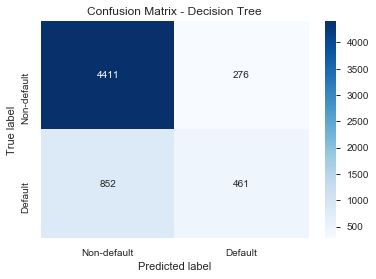

In [14]:
ConfMatrix = confusion_matrix(y_test,classifier.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

A confusion matrix is showing the frequency of misclassification of our classifier.


Our y_test has a total of 6000 data points; which we got by spliting our dataset in order to evaluate our model. Each number here represents certain details about our model. If we were to think about this in terms of column and raw, we could see that...

- the first column is of data points that the machine predicted as non-default.
- the second column is of the statistics that the model predicted as default.
- In terms of raws, the first raw indexed as non-default means that the value in that raw are actual statistics of default value.

Now we can see that the predicted non-default and predicted default sort of overlap with actual default and actual non-default. After all it is a matrix and we have some terminologies to call these statistics more specifically. Let's see what they are and determine the value of all these terminologies. 

- **True Positive(TP):** values that the model predicted as yes(default) and is actually yes(default).
    - Here its value is 461
- **True Negative(TN):** values that model predicted as no(non-default) and is actually no(non-default)
    - Here its value is 4411
- **False Positive(or Type I error):** values that model predicted as yes(default) but actually no(non-default)
    - Here its value is 276
- **False Negative(or Type II error):** values that model predicted as no(non-default) but actually yes(default)
    - Here its value is 852


From these four terminologies, we can compute many other rates that are used to evaluate a binary classifier.
Accuracy:
Accuracy is the measure of how often the model is correct.

`(TP + TN)/total = (461+4411)/6000 = .812`

I got the same value from scikit learn.

## Misclassification Rate: 

**Misclassification Rate is the measure of how often the model is wrong**

- Misclassification Rate and Accuracy are opposite of each other.
- Misclassification is equivalent to 1 minus Accuracy.
- Misclassification Rate is also known as "Error Rate".

`(FP + FN)/Total = (276+852)/6000 = 0.188`



In [15]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, predictions))

0.188
0.18799999999999994


**True Positive Rate/Recall/Sensitivity:** 

Sensitivity: When the actual value is positive, how often is the prediction correct?

- Something we want to maximize
- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

`TP/(TP+FN) = 461/(461+852) = 0.351104`

In [16]:
#recall_score(y_test, predictions)
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, predictions))

0.3511043412033511
0.3511043412033511


**True Negative Rate/Specificity:** 

Specificity: When the actual value is negative, how often is the prediction correct?

- Something we want to maximize
- How "specific" (or "selective") is the classifier in predicting positive instances?
- True Negative Rate is equivalent to 1 minus False Positive Rate.

`TN/(TN+FP) = 4411/(4411+276) = 0.941113719`

In [17]:
specificity = TN / (TN + FP)

print(specificity)

0.9411137187966716


Here we can see our classifier is 
- Highly specific
- Not sensitive

**False Positive Rate:** 

When the actual value is negative, how often is the prediction incorrect?

`FP/(FP+TN) = 276/(276+4411) = 0.0588862812`

In [18]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.05888628120332835
0.058886281203328394


**Precision:** 

Precision: When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

`TP/(TP+FP) = 461/(461+276) = 0.0.62550882`

In [19]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, predictions))

0.6255088195386703
0.6255088195386703


In [20]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.63      0.35      0.45      1313

   micro avg       0.81      0.81      0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



we have our confusion matrix. Now we will give it a little more character.

Confusion matrix, without normalization
[[4411  276]
 [ 852  461]]
Normalized confusion matrix
[[0.94 0.06]
 [0.65 0.35]]


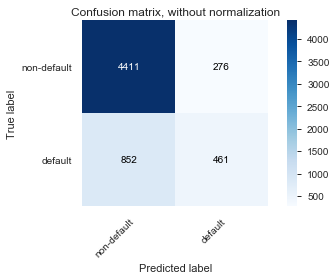

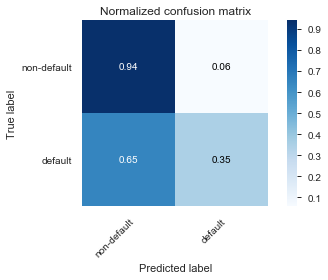

In [21]:
def plot_confusion_matrix(y_true, predictions, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, predictions)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, predictions)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = np.array(['non-default','default'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Validation Curve
Here I will use AdaBoostClassifier.  




# Ensemble Machine Learning

An ensemble model is a composite model which combines a series of low performing or weak classifiers with the aim of creating a strong classifier. Here, individual classifiers vote and final prediction label returned that performs majority voting. These individual classifiers are combined according to some specific criterion to create an ensemble model. Thats why these ensemble models offer greater accuracy than individual or base classifiers.

Ensemble models are created according to some specific criterion as stated below:-

- **Bagging** - They can be created to decrease model variance using bagging approach.

- **Boosting** - They can be created to decrease model bias using a boosting approach.

- **Stacking** - They can be created to improve model predictions using stacking approach.


![image_1_joyt3x](https://user-images.githubusercontent.com/14244685/79098281-79732b00-7d83-11ea-911a-22058b24f99e.png)



# AdaBoost (Adaptive Boosting)

AdaBoostClassifier stands for Adaptive Boosting Classifier.

Ada Boost is the first original boosting technique which creates a highly accurate prediction rule by combining many weak and inaccurate rules. It is a boosting ensemble model and works especially well with the decision tree. Boosting model's key is learning from the previous mistakes, e.g. misclassification data points.

**AdaBoost learns from the mistakes by increasing the weight of misclassified data points.**




**Step 1:** *Initialize the weights* of data points. if the training set has 100 data points, then each point's initial weight should be 1/100 = 0.01.

**Step 2:** *Train* a decision tree

**Step 3:** *Calculate the weighted error rate (e)* of the decision tree. *The weighted error rate (e)* is just how many wrong predictions out of total and you treat the wrong predictions differently based on its data point's weight. *The higher the weight*, the more the corresponding error will be weighted during the calculation of the (e).

**Step 4:** *Calculate this decision tree's weight* in the ensemble

`the weight of this tree = learning rate * log( (1 - e) / e)`

- the higher weighted error rate of a tree, the less decision power the tree will be given during the later voting
- the lower weighted error rate of a tree, the higher decision power the tree will be given during the later voting

**Step 5:** *Update weights* of wrongly classified points

the weight of each data point =
- if the model got this data point correct, the weight stays the same
- if the model got this data point wrong, the new weight of this point = old weight * np.exp(weight of this tree)

Note: The higher the weight of the tree (more accurate this tree performs), the more boost (importance) the misclassified data point by this tree will get. The weights of the data points are normalized after all the misclassified points are updated.

**Step 6:** *Repeat* Step 1(until the number of trees we set to train is reached)

**Step 7:** *Make the final prediction*

The AdaBoost makes a new prediction by adding up the weight (of each tree) multiply the prediction (of each tree). The tree with higher weight will have more power of influence the final decision.



For a learned classifier to make strong predictions it should follow the following three conditions:

- The rules should be simple
- Classifier should have been trained on sufficient number of training examples
- The Classifier should have low training error for the training instances


Each of the weak hypothesis has an accuracy slightly better than random guessing i.e. Error Term € (t) should be slightly more than ½-β where β >0. This is the fundamental assumption of this boosting algorithm which can produce a final hypothesis with a small error

After each round, it gives more focus to examples that are harder to classify.  The quantity of focus is measured by a weight, which initially is equal for all instances. After each iteration, the weights of misclassified instances are increased and the weights of correctly classified instances are decreased.


### Advantages
- Very Simple to implement
- Good generalization- suited for any kind of classification problem ü Not prone to overfitting
- It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners.
- We can use many base classifiers with AdaBoost.


### Disadvantages
- Sensitive to noisy data and outliers
- It is highly affected by outliers because it tries to fit each point perfectly.
- AdaBoost is slower compared to XGBoost.


In [22]:
min_train = X_train.min()
range_train = (X_train - min_train).max()
X_train_scaled = (X_train - min_train)/range_train

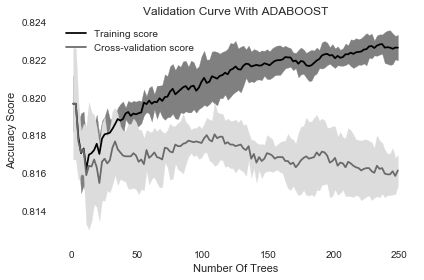

In [23]:
# Create range of values for parameter
param_range = np.arange(1, 250, 2)
# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(AdaBoostClassifier(), 
                                             X_train_scaled, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With ADABOOST")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

**Interpretation of the Validation Curve**

if the number of trees are around 10, then the model suffers from high bias. Two scores are quite close,but both the scores are too far from acceptable level so I think it's a high bias problem.In other words, the model is underfitting.

At a maximun number of trees of 250, model suffers from high variance since training score is 0.82 but validation score is about 0.81.In other words, a model is overfitting. Again, the data points suggest a sort of graceful curve. However, our model uses a very complex curve to get as close to every data point as possible. Consequently, a model with high variance has very low bias because it makes little to no assumption about the data. In fact, it adapts too much to the data.

As we see from the curve, max trees of around 30 to 40 best generalizes the unseen data. As max trees increases, bias becomes lower and variance becomes higher. We should keep the balance between the two. Just after 30 to 40 number of trees training score increase upwards and validation score starts to goes down, so I it begins to suffer from overfitting. So that's why any number of trees between 30 and 40 should be a good choice.

# Support Vector Machine 

Support Vector Machine (SVM) is one of the most popular classification techniques which aims to minimize the number of misclassification errors directly. 

In [24]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

svc = LinearSVC(C=1.0)

model = svc.fit(features_standardized, target)

c:\users\humayra\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\humayra\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Handling Linearly Inseparable Classes Using Kernels


In [25]:
np.random.seed(0)

features = np.random.randn(200, 2)

target_xor = np.logical_xor(features[:, 0] > 0, features[:, 1] > 0)
target = np.where(target_xor, 0, 1)

svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

model = svc.fit(features, target)

## Discussion 



For reasons best learned elsewhere, a support vector classifier can be represented as:

$$
f(x) = \beta_0 + \sum_{i\in s}^{p}{\alpha_i K(x_i, x_{i'})}
$$

where \beta is the bias, S is the set of all support vector observations, \alpha are the model parameters to be learned, and $(x_i, x_{i'})$ are pairs of two support vector observations, $x_i$ and $x_{i;}$. Don't worry if you don't understand kernel functions. For our purposed, just realized that K

1. Determines the type of hyperplane used to separate our classes and
2. we create different hyperplanes by using different kernels.

For example if we wanted the basic linear hyperplane used to separate our classes, we can use the linear kernel:

$$
K(x_i, x_{i'}) = \sum_{j=1}^{p}{x_{ij}x_{i'j}}
$$

where p is the number of features. However, if we wanted a nonlinear decision boundary, we swap the linear kernel with a polynomial kernel:

$$
K(x_i, x_{i'}) = (1 + \sum_{j=1}^{p}{x_{ij}x_{i'j}})^2
$$

where d is the degree of the polynomial kernel function. Alternatively, we can use one of the most common kernels in support vector machines, the radial basis function kernel:

$$
K(x_i, x_{i'}) = e^{(-\gamma \sum_{j=1}^{p}{(x_{ij}x_{i'j})^2})}
$$

where \gamma is a hyperparameter and must be greater than zero. The main point of the preceding explanation is that if we have linearly inseparable data we can swap out a linear kernel with an alternative kernel to create a nonlinear hyperplane decision boundary.




Radial Basis Function is a commonly used kernel in SVC. an SVC classifier using an RBF kernel has two parameters: `gamma` and `C`.

### Gamma
gamma is a parameter of the RBF kernel and can be thought of as the ‘spread’ of the kernel and therefore the decision region. When gamma is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad. When gamma is high, the ‘curve’ of the decision boundary is high, which creates islands of decision-boundaries around data points. We will see this very clearly below.

### C
C is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is small, the classifier is okay with misclassified data points (high bias, low variance). When C is large, the classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance).




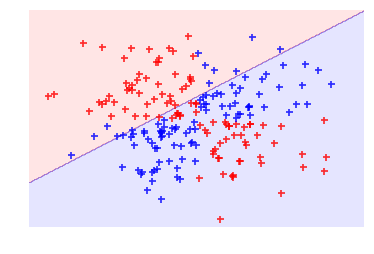

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [26]:
def plot_decision_regions(X, y, classifier):
    cmap = ListedColormap(("red", "blue"))
    xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker="+", label=cl)
        
svc_linear = SVC(kernel="linear", random_state=0, C=1)

svc_linear.fit(features, target)
plot_decision_regions(features, target, classifier=svc_linear)
plt.axis("off"), plt.show()

## Gamma
In the four charts below, we apply the same SVC-RBF classifier to the same data while holding C constant. The only difference between each chart is that each time we will increase the value of gamma. By doing so, we can visually see the effect of gamma on the decision boundary.


### Gamma = 0.01


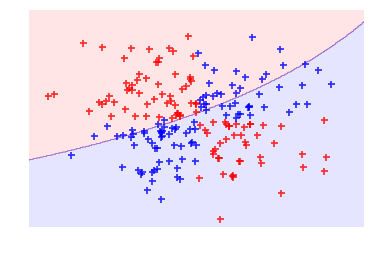

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [27]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

In the case of our SVC classifier and data, when using a low gamma like 0.01, the decision boundary is not very curvy, rather it is just one big sweeping arch.


### Gamma = 1


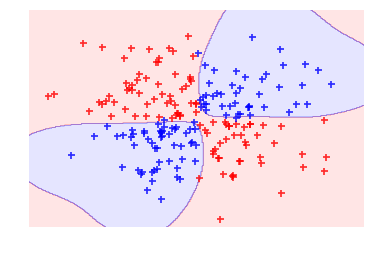

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [28]:
svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

We can see a big difference when we increase the gamma to 1. Now the decision boundary is starting to better cover the spread of the data.


### Gamma = 10


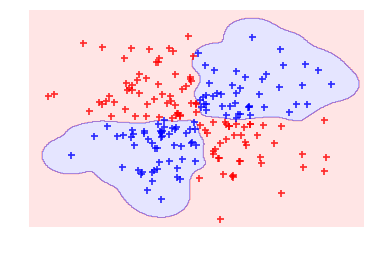

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [29]:
svc = SVC(kernel="rbf", random_state=0, gamma=10, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At `gamma = 10` the spread of the kernel is less pronounced. The decision boundary starts to be highly effected by individual data points (i.e. variance).


### Gamma = 100


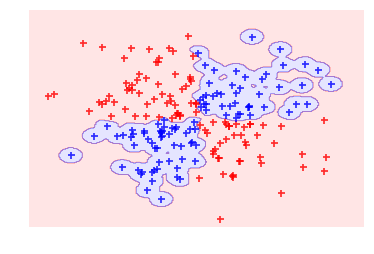

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [30]:
svc = SVC(kernel="rbf", random_state=0, gamma=100, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

With high gamma, the decision boundary is almost entirely dependent on individual data points, creating islands. This data is clearly overfitted.

## C - The Penalty Parameter
Now we will repeat the process for C: we will use the same classifier, same data, and hold gamma constant. The only thing we will change is the C, the penalty for misclassification.


### C = 1


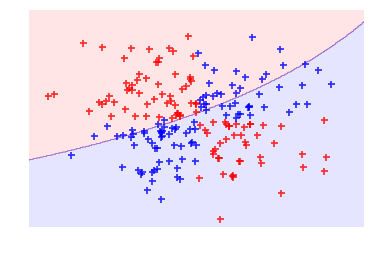

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [31]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

With C = 1, the classifier is clearly tolerant of misclassified data point. There are many red points in the blue region and blue points in the red region.



### C = 10


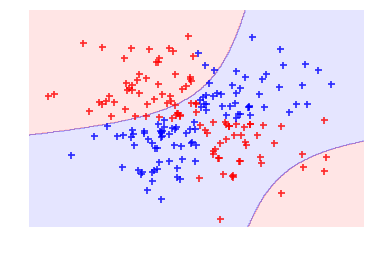

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [32]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=10)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 10, the classifier is less tolerant to misclassified data points and therefore the decision boundary is more severe.


### C = 100

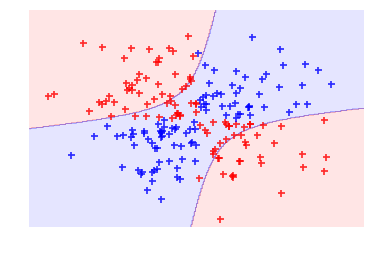

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [33]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=100)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

### C = 1000

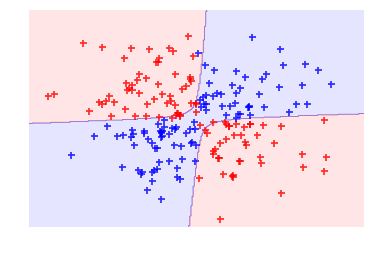

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [34]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=1000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

When C = 1000, the classifier starts to become very intolerant to misclassified data points and thus the decision boundary becomes less biased and has more variance (i.e. more dependent on the individual data points).

### C = 10000

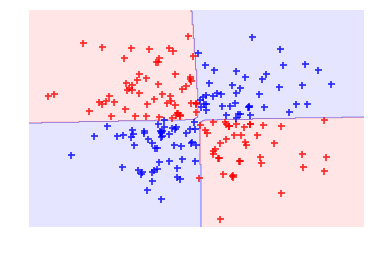

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [35]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=10000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 10000, the classifier “works really hard” to not misclassify data points and we see signs of overfitting.

### C = 100000

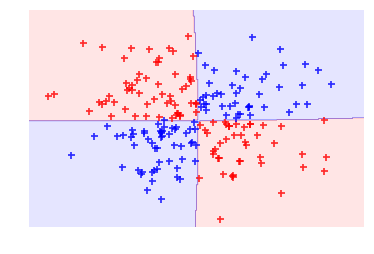

((-3.0, 2.9800000000000058, -3.0, 2.9800000000000058), None)

In [36]:
svc = SVC(kernel="rbf", random_state=0, gamma=0.01, C=100000)
model = svc.fit(features, target)
plot_decision_regions(features, target, classifier=svc)
plt.axis("off"), plt.show()

At C = 100000, the classifier is heavily penalized for any misclassified data points and therefore the margins are small.

So from above plots, we can come to conclusion that if your data has some amount of overlap or the classifier can be misclassified. 

We can see, very large $C$, the margin is hard, and points cannot lie in it.
And for smaller $C$, the margin is softer, and can grow to encompass some points.

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure

In [37]:
features = np.random.randn(200, 2)

target_xor = np.logical_xor(features[:, 0] > 0, features[:, 1] > 0)
target = np.where(target_xor, 0, 1)

svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

model = svc.fit(features, target)

## Overview of Support Vector Machine Summary

Support vector machine is a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.